In [1]:
!pip install geopandas
!pip install geoplot

In [2]:

# import the geospatial data visualization package
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import os
import urllib
import mimetypes
import mapclassify as mc
from google.colab import drive
import folium	
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

## setting path
# get current path
path_current = os.getcwd()
# the path is where the dataset saved
path = path_current + '/drive/My Drive/Visualization/Data/' 
# the "path_img" is the position where final image will be saved
path_img = path_current + '/drive/My Drive/Visualization/Images/'

In [4]:
class Map:
    # read data
    def read_file(self, file, longtitude, latitude):
        """Read different types of files and return geopandas dataframe.

        This function can transform multiple file type such as csv/geojson into
        a pandas dataframe. User need to input the filename such as: 'file.csv'.
        If the file type cannot be find or not support it, it will return the message.

        Args:
            file: filename of user data source

        Returns:
            data : A geopandas dataframe

        """
        file_url = urllib.request.pathname2url(file)  # try catch
        ftype = file_url.split(".")[-1]
        ## read data file according to its formate, default includes three types of files: csv/geojson
        # read csv format data from the parking dataset
        if 'csv' in ftype:
            # read the csv file into the pandas dataframe
            csv = pd.read_csv(path + file)
            # transfer the pandas dataframe become geopandas dataframe base on longtitude and latitude
            data = gpd.GeoDataFrame(csv,
                                    geometry=gpd.points_from_xy(
                                        csv[longtitude], csv[latitude]))
        # transfer geojson data into geopandas dataframe
        elif 'geojson' in ftype:
            data = gpd.read_file(path + file)
        # warning for the incorect file
        else:
            print("File type cannot find!")
        return data

    def read_routefile(self, file):
        """Read different types of files and return pandas dataframe.

        This function can transform multiple file type such as csv/excel/text into
        a pandas dataframe. User need to input the filename such as: 'file.csv'.
        If the file type cannot be find or not support it, it will return the message.

        Args:
            file: filename of user data source

        Returns:
            data : A pandas dataframe

        """
        # Get the file URL
        file_url = urllib.request.pathname2url(file)  # try catch
        # use mimetypes package to guess the file type
        # For example: 'file.csv' will return 'csv'
        ftype = mimetypes.guess_type(file_url, strict=True)[0]
        ## read data file according to its formate, default includes three types of files: csv/excel/text
        # read csv format data
        if 'csv' in ftype:
            data = pd.read_csv(path + file)
        # read excel format data
        elif 'sheet' in ftype:
            data = pd.read_excel(path + file)
        # read text format data from
        elif ftype == 'text/plain':
            data = pd.read_csv(path + file, sep="\t")
        else:
            print("File type cannot find!")
        return data

    # file: file name of your data source
    # x_col_name: ['index'] or ['x_column_name_a','x_column_name_b'...]
    # y_col_name: ['y_column_name_a','y_column_name_b'...]
    # x_label: x axis label
    # y_label: y axis label
    # legend_label: legend labels names
    # plot_type: type of plot: stack or simple
    # paper_type : 'single' or 'double'
    def map_plot(self, base_file, output_name, **kwargs):
        """Geospatial data visualization map with multiple plot

        To use this function, it have to import the base_file which contain the polygon shape.
        The user can select multiple overlay type such as point, kde, sankey,choropleth,path.
        The inital overlay type is point(scatter).

        Args:
            base_file: The file name of base file, it need to conatin ploygons.
            output_name: The output file name

        """

        conf = {
            'plotwidth': 10,  # weight,
            'file_longtitude': 'longtitude',
            'file_latitude': 'latitude',
            'polyplot_linewidth': 1,
            'polyploy_facecolor': 'lightgrey',
            'polyplot_figsize': (16, 12),
            'kde_cmap': 'Reds',
            'kde_shade': True,
            'kde_shade_lowest': True,
            'kde_alpha': 0.8,
            'pointplot_edgecolor': 'black',
            'pointplot_linewidth': 0.5,
            'pointplot_alpha': 0.8,
            'pointplot_legend': True,
            'choropleth_figsize': (16, 8),
            'choropleth_legend': True,
            'choropleth_hue': '',
            'choropleth_cmap': 'Reds',
            'sankey_limits': (0.1, 10),
            'sankey_color': 'black',
            'sankey_figsize': (16, 12),
            'title_fontsize': 20,
            'overlay_type': 'point',
            'overlay_file': '',
            'sankey_plot': False,
            'sankey_scale': '',
            'cartogram_scale': '',
            'cartogram_legend': True,
            'cartogram_cmap': 'Reds',
            'cartogram_hue': '',
            'cartogram_num_legend': 5,
            'path_scale': '',
            'path_legend': True,
            'path_cmap': 'Blues',
            'path_hue': '',
            'path_num_legend': 5,
            'legend_title': '',
            'plot_title': ''
        }

        # when new configuraton is set, update the original one
        conf.update(kwargs)

        # read ploygon file
        try:
            poly_data = self.read_file(file=base_file,
                                       longtitude=conf['file_longtitude'],
                                       latitude=conf['file_latitude'])
        except Exception:
            print(
                'Sorry, this ploygon/base file does not exist, please check the file name'
            )

        if conf['sankey_plot'] == False:
            # read overlay file
            try:
                overlay_data = self.read_file(
                    file=conf['overlay_file'],
                    longtitude=conf['file_longtitude'],
                    latitude=conf['file_latitude'])
            except Exception:
                print(
                    'Sorry, this overlay file does not exist, please check the file name'
                )

            # The polyplot draws polygons on a map, The base file contains the polygons column
            ax = gplt.polyplot(df=poly_data,
                               linewidth=conf['polyplot_linewidth'],
                               facecolor=conf['polyploy_facecolor'],
                               figsize=conf['polyplot_figsize'])
            """ 
            The pointplot is a geospatial scatter plot that represents each observation in your dataset as 
            a single point on a map. It is simple and easily interpretable plot, making it an ideal choice for 
            showing simple pointwise relationships between observations.
            """
            if conf['overlay_type'] == 'point':
                # pointplot
                gplt.pointplot(df=overlay_data,
                               edgecolor=conf['pointplot_edgecolor'],
                               linewidth=conf['pointplot_linewidth'],
                               alpha=conf['pointplot_alpha'],
                               ax=ax)

            elif conf['overlay_type'] == 'kde':
                # kde
                """
                Kernel density estimation is a technique that non-parameterically estimates a distribution function
                for a sample of point observations. KDEs are a popular tool for analyzing data distributions; 
                this plot applies this technique to the geospatial setting.
                """
                ax = gplt.kdeplot(df=overlay_data,
                                  cmap=conf['kde_cmap'],
                                  shade=conf['kde_shade'],
                                  shade_lowest=conf['kde_shade_lowest'],
                                  alpha=conf['kde_alpha'],
                                  ax=ax)

            # Combine point plot and kde plot together
            elif conf['overlay_type'] == 'both':

                # pointplot
                gplt.pointplot(df=overlay_data,
                               edgecolor=conf['pointplot_edgecolor'],
                               linewidth=conf['pointplot_linewidth'],
                               alpha=conf['pointplot_alpha'],
                               ax=ax)

                # kde
                ax = gplt.kdeplot(df=overlay_data,
                                  cmap=conf['kde_cmap'],
                                  shade=conf['kde_shade'],
                                  shade_lowest=conf['kde_shade_lowest'],
                                  alpha=conf['kde_alpha'],
                                  ax=ax)

            elif conf['overlay_type'] == 'choropleth':

                # choropleth plot
                ax = gplt.choropleth(df=overlay_data,
                                     hue=conf['choropleth_hue'],
                                     figsize=conf['choropleth_figsize'],
                                     legend=conf['choropleth_legend'],
                                     cmap='terrain',
                                     ax=ax)

            elif conf['overlay_type'] == 'path':
                """
                A Path diagram visualizes flow through a network. It can be used to show the magnitudes of data moving
                through a system. This plot brings the Sankey diagram into the geospatial context; useful for
                analyzing traffic load a road network.
                """
                scheme = mc.Quantiles(overlay_data[conf['path_scale']],
                                      k=conf['path_num_legend'])
                ax = gplt.sankey(overlay_data,
                                 scale=conf['path_scale'],
                                 hue=conf['path_hue'],
                                 scheme=scheme,
                                 cmap=conf['path_cmap'],
                                 legend=conf['path_legend'],
                                 legend_kwargs={
                                     'loc': 'lower left',
                                     'title': conf['legend_title'],
                                     'title_fontsize': 12,
                                     'fontsize': 12,
                                     'shadow': True,
                                 },
                                 ax=ax)

            elif conf['overlay_type'] == 'cartogram':
                """
                A cartogram distorts (grows or shrinks) polygons on a map according to the magnitude of
                some input data. A basic cartogram specifies data, a projection, and a scale parameter.
                """
                scheme = mc.Quantiles(overlay_data[conf['cartogram_scale']],
                                      k=conf['cartogram_num_legend'])
                ax = gplt.cartogram(
                    df=overlay_data,
                    scale=conf['cartogram_scale'],
                    hue=conf['cartogram_hue'],
                    cmap=conf['cartogram_cmap'],
                    legend=conf['cartogram_legend'],
                    legend_kwargs={
                        'loc': 'lower left',
                        'title': conf['legend_title'],
                        'title_fontsize': 12,
                        'fontsize': 12,
                        'shadow': True,
                    },
                    scheme=scheme,
                    ax=ax,
                )

            # warning for the wrong overlay_type
            else:
                print(
                    "You didn't enter the right overlay_type, please try again"
                )

        # A Sankey diagram visualizes flow through a network.
        if conf['sankey_plot'] == True:
            # sankey plot
            gplt.sankey(df=poly_data,
                        scale=conf['sankey_scale'],
                        limits=conf['sankey_limits'],
                        color=conf['sankey_color'],
                        legend=True,
                        figsize=conf['sankey_figsize'])

        # plot title
        plt.title(conf['plot_title'], fontsize=conf['title_fontsize'])

        # save the plot
        plt.tight_layout()
        plt.savefig(path_img + output_name)

    def route_map(self, file, **kwargs):
        """The route map with multiple stop
        In this function, It can draw the route base on longtitude and latitude.

        Args:
            file: The file name of route_map file, it need to conatain longtitude and latitude.

        """

        conf = {
            'latitude': 'latitude',
            'longtitude': 'longtitude',
            'map_location': [-37.81, 144.955],
            'map_zoom': 15,
            'icon_color': 'green',
            'icon_style': 'plus',
            'line_color': 'red'
        }

        # when new configuraton is set, update the original one
        conf.update(kwargs)

        # read the file and return the pandas dataframe
        try:
            data = self.read_routefile(file=file)
        except Exception:
            print(
                'Sorry, this ploygon/base file does not exist, please check the file name'
            )

        # Get the list of all latitude
        latitude = data[conf['latitude']].to_list()

        # Get the list of all longtitude
        longtitude = data[conf['longtitude']].to_list()

        # create the base map
        map = folium.Map(location=conf['map_location'],
                         zoom_start=conf['map_zoom'])

        # combine the latitude and longtitude become a point
        points = []
        for i in range(len(latitude)):
            points.append([latitude[i], longtitude[i]])

        # add the marker based on the location
        for index, lat in enumerate(latitude):
            folium.Marker([lat, longtitude[index]],
                          popup=('location{}'.format(index)),
                          icon=folium.Icon(
                              color=conf['icon_color'],
                              icon=conf['icon_style'])).add_to(map)

        # connect the line with each points
        folium.PolyLine(points, color=conf['line_color']).add_to(map)

        # display the map
        display(map)


In [5]:
m5 = Map()
m5.route_map(file='mel_city.csv',latitude='latitude',longtitude='longtitude')

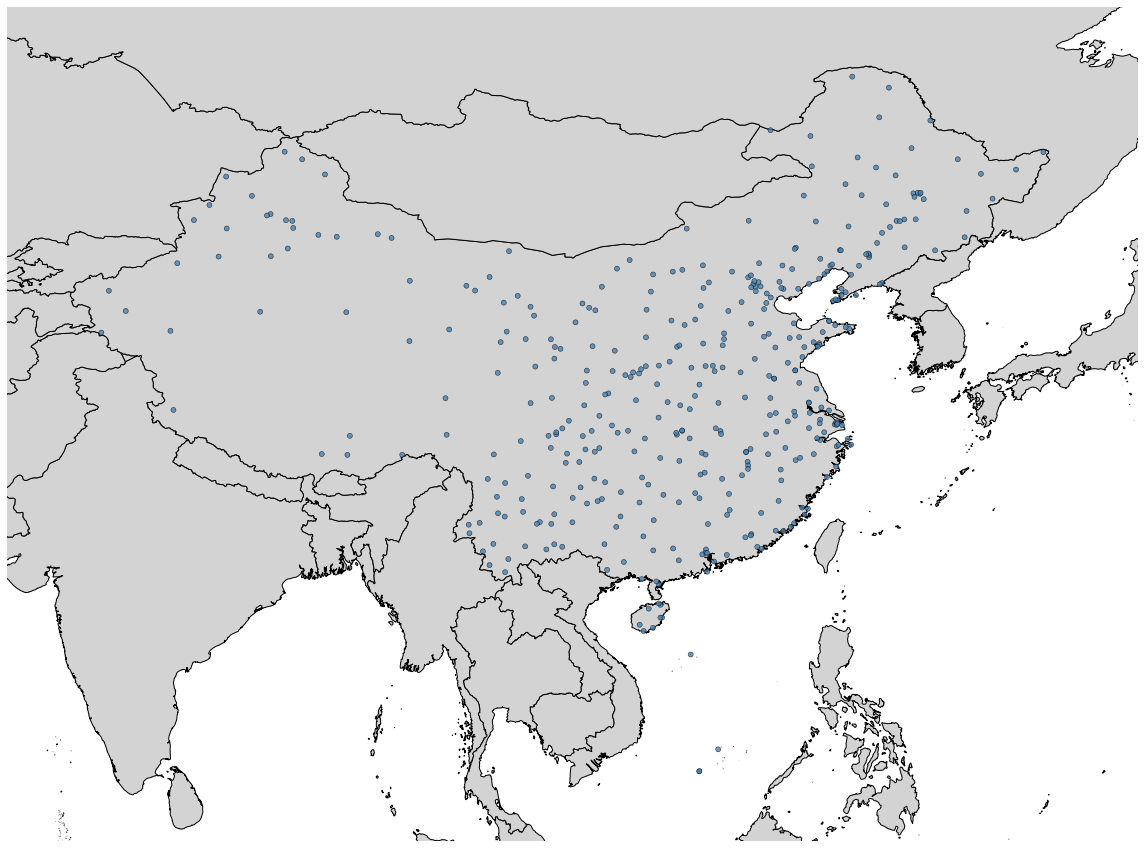

In [6]:
m4 = Map()
m4.map_plot(base_file='countries.geojson',overlay_file='list-of-airports-in-china-hxl-tags-1.csv',
            file_latitude='latitude_deg',file_longtitude='longitude_deg',output_name='point.jpg')

In [ ]:
m4.map_plot(base_file='countries.geojson',overlay_file='list-of-airports-in-china-hxl-tags-1.csv', overlay_type='kde',
         file_latitude='latitude_deg',file_longtitude='longitude_deg',output_name='kde.jpg')

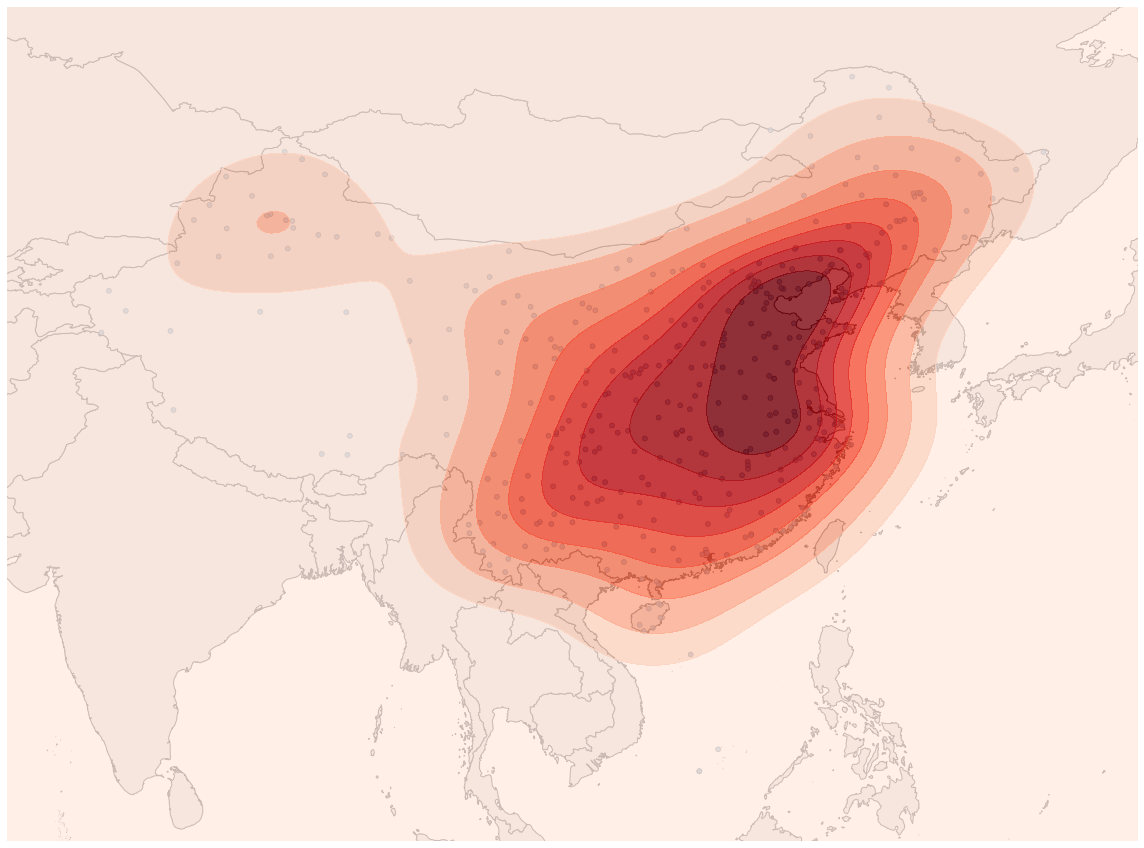

In [7]:
m4.map_plot(base_file='countries.geojson',overlay_file='list-of-airports-in-china-hxl-tags-1.csv', overlay_type='both',
         file_latitude='latitude_deg',file_longtitude='longitude_deg',output_name='point+kde.jpg')

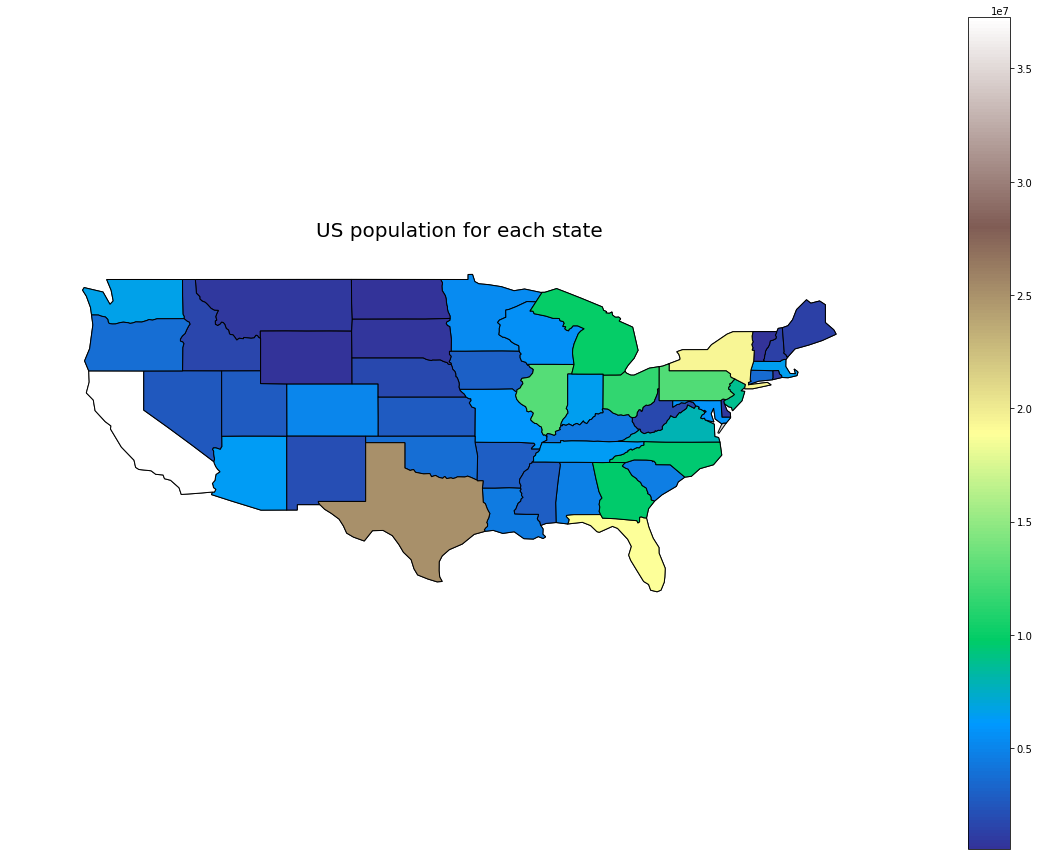

In [8]:
m2 = Map()
m2.map_plot(base_file='admin1-us.geojson',overlay_file='new.geojson',overlay_type='choropleth',choropleth_hue='population', plot_title='US population for each state',output_name='choropleth.jpg')

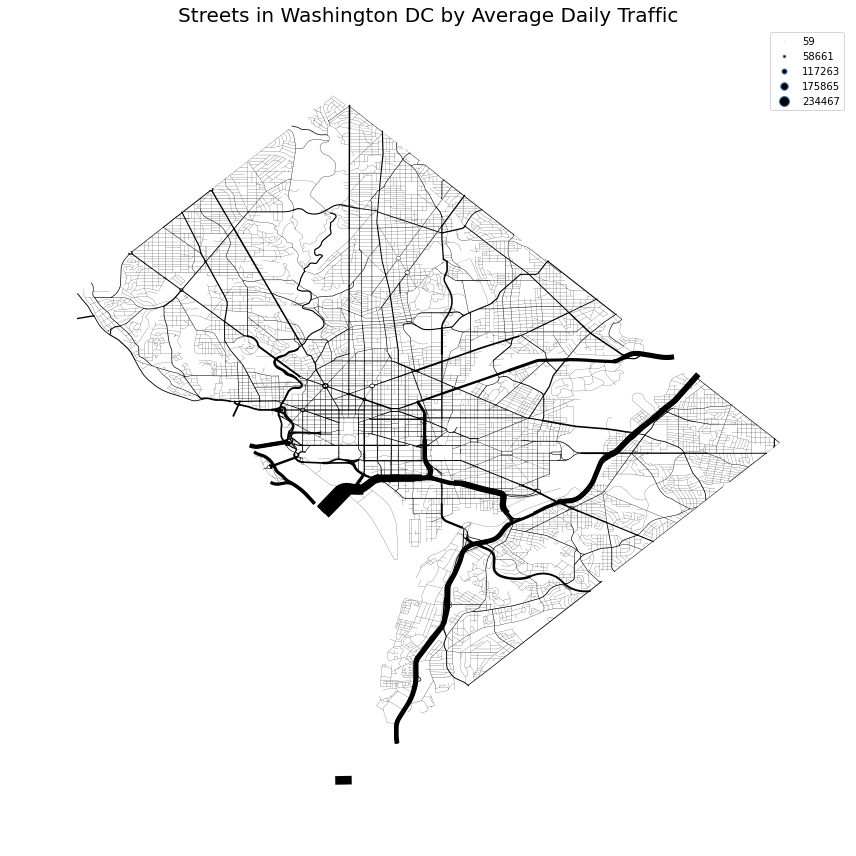

In [9]:
m3 = Map()
m3.map_plot(base_file='dc-roads.geojson', sankey_plot=True,sankey_scale='aadt', plot_title='Streets in Washington DC by Average Daily Traffic',output_name='sankey.jpg')

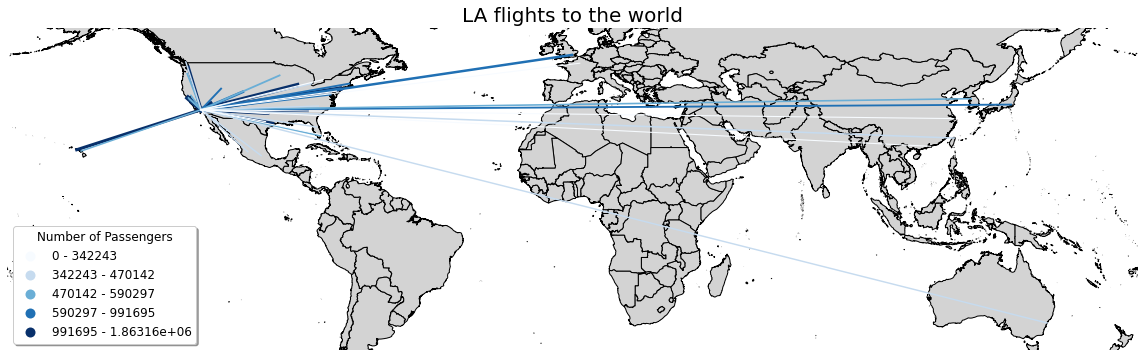

In [10]:
m5 = Map()
m5.map_plot(base_file='countries.geojson',overlay_file='la-flights.geojson',overlay_type='path',path_scale='Passengers', path_hue='Passengers',
            plot_title='LA flights to the world',legend_title='Number of Passengers',output_name='path.jpg')

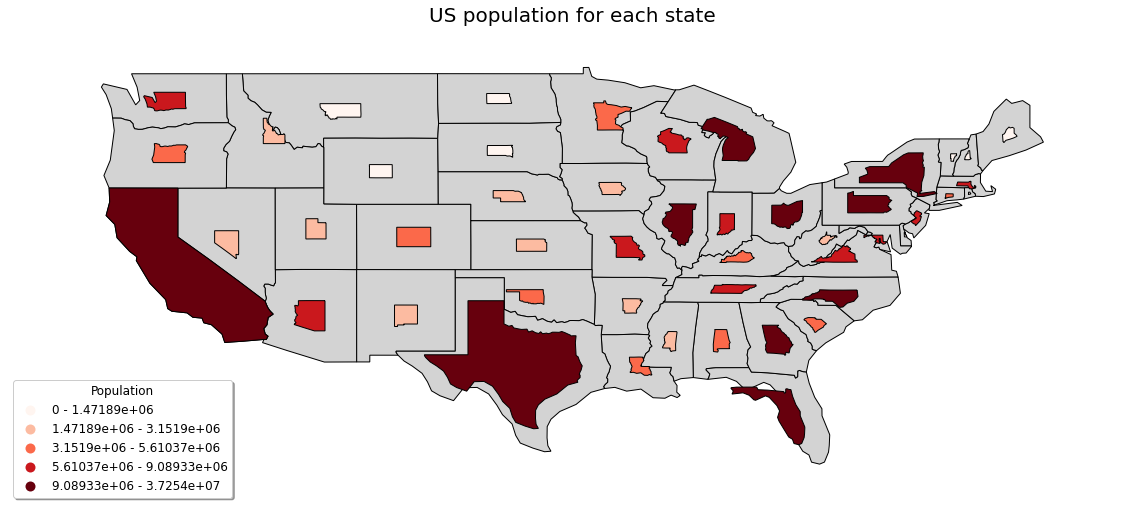

In [11]:
m6 = Map()
m6.map_plot(base_file='contiguous-usa.geojson',overlay_file='contiguous-usa.geojson',overlay_type='cartogram', cartogram_scale='population',
            cartogram_hue='population',plot_title='US population for each state',legend_title='Population',output_name='cartogram.jpg')